<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import warnings;warnings.simplefilter('ignore')
import random
import numpy as np
from time import sleep
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import nd, autograd
import gym

# define policy and value net

In [0]:
class Net(gluon.Block):
    def __init__(self, actions_count):
        super(Net, self).__init__()
        with self.name_scope():
            self.dense = gluon.nn.Dense(128, activation='tanh')
            self.dense2 = gluon.nn.Dense(128, activation='relu')
            self.action_pred = gluon.nn.Dense(actions_count, in_units=128)
            self.value_pred = gluon.nn.Dense(1, in_units=128)

    def forward(self, x):
        x = self.dense(x)
        x = self.dense2(x)
        probs = self.action_pred(x)
        values = self.value_pred(x)
        return mx.ndarray.softmax(probs), values

In [3]:
env = gym.make("CartPole-v1")
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
print(state_dim,action_dim)

4 2


# loss and optimizer

In [0]:
#  Model initialization and loss method
loss = gluon.loss.L2Loss()
model = Net(action_dim)
model.collect_params().initialize(mx.init.Xavier())
optimizer = gluon.Trainer(model.collect_params(),'Adam',{'learning_rate': 0.001})

# main loop

In [5]:
all_rewards = []
avg_rewards = []

for episode in range(1000):

  # reset placeholder
  rewards = []
  values = []
  actions = []
  heads = []
  state = env.reset()
  total = 0
  
  with autograd.record():
    for learning_step in range(1000):
      
      # nd_array state
      state = nd.array(np.expand_dims(state, 0))
      
      # choose action and do action on env
      prob, value = model(state)
      action, logp = mx.nd.sample_multinomial(prob, get_prob=True)
      action = action.asnumpy()[0].astype(np.int64)
      next_state, reward, done, info = env.step(action)
      
      # record data
      total += reward
      rewards.append(reward)
      actions.append(action)
      values.append(value)
      heads.append(logp)

      # is game over?  
      if done:
        break
      else:
        state = next_state
    
    # record
    all_rewards.append(total)
    avg_rewards.append(np.mean(all_rewards[-10:]))
    
    # print infomation
    if episode % 10 == 0:
      print(episode,total)
    
    # if solved break
    if (total >= 500)&(avg_rewards[-1] >= 500*0.9):
      print(episode,total,avg_rewards[-1])
      break
        
    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards) - 1, -1, -1):
      R = rewards[i] + 0.99 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps

    # critic loss
    L = sum([loss(value, mx.nd.array([r])) for r, value in zip(rewards, values)])
    final_nodes = [L]
    
    # actor loss
    for logp, r, v in zip(heads, rewards, values):
      reward = r - v.asnumpy()[0, 0]
      final_nodes.append(logp * (-reward))
  
  # loss backward
  autograd.backward(final_nodes)
  optimizer.step(len(final_nodes))

0 10.0
10 21.0
20 23.0
30 24.0
40 48.0
50 31.0
70 64.0
80 49.0
90 128.0
100 23.0
110 27.0
120 159.0
130 182.0
140 188.0
150 79.0
160 90.0
170 397.0
180 151.0
190 500.0
200 287.0
210 184.0
220 207.0
230 172.0
240 167.0
250 286.0
260 218.0
270 308.0
280 295.0
290 481.0
300 354.0
310 353.0
320 333.0
330 215.0
340 461.0
341 500.0 464.7


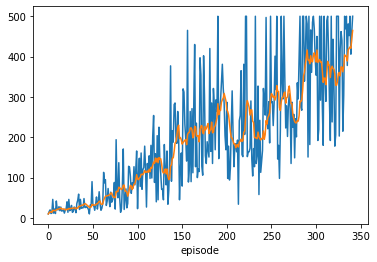

In [6]:
import matplotlib.pyplot as plt
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('episode')
plt.show()

# test

In [14]:
for episode in range(10):
  state = env.reset()
  total = 0
  for t in range(1000):
    # nd_array state
    state = nd.array(np.expand_dims(state, 0))    
    
    # choose action and do action on env
    prob, value = model(state)
    action = np.argmax(prob.asnumpy())
    next_state, reward, done, info = env.step(action)
    
    # record total
    total += reward
    
    # is game over?  
    if done:
      break
    else:
      state = next_state
  
  print(episode,total)

0 500.0
1 500.0
2 500.0
3 500.0
4 500.0
5 500.0
6 500.0
7 500.0
8 500.0
9 500.0
